In [1]:
from torchvision import models
from torchvision import transforms
import torch.nn as nn
from PIL import Image
import numpy as np
import torch
import torch.optim as optim
from torchmetrics.functional import total_variation
from tqdm import tqdm
import matplotlib.pyplot as plt

img = Image.open("dog.jpg")


alexnet = models.alexnet(pretrained=True)
alexnet.eval()


transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
 )])


img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)

print(batch_t.shape)

out = alexnet(batch_t)
print(out.shape)

C:\Users\Piotr MX Labs\Desktop\nauka\deep-learning\deep-dream-experiments\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Piotr MX Labs\Desktop\nauka\deep-learning\deep-dream-experiments\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 3, 224, 224])
torch.Size([1, 1000])


In [207]:
# class NonFullyConnectedLinear(nn.Module):
#     def __init__(self, in_channels=3):
#         super(NonFullyConnectedLinear, self).__init__()
#         self.weight = nn.Parameter(torch.rand((in_channels, 224, 224), requires_grad=True))
#         self.bias = nn.Parameter(torch.rand((in_channels, 224, 224), requires_grad=True))

#     def forward(self, x):
#         return torch.mul(x, self.weight) + self.bias
    
class ImageLayer(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.weight = nn.Parameter(torch.rand((in_channels, 224, 224), requires_grad=True)) # 224
        
    def init_layer(self, image_batch):
        self.weight.data = image_batch[0, ...]
    
    def forward(self):
        return torch.unsqueeze(torch.mul(1, self.weight), 0)


In [186]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [255]:
class DeepDream(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = models.vgg16(pretrained=True)#models.inception_v3(pretrained=True)#models.alexnet(pretrained=True) # alexnet
        self.modify = ImageLayer()
        self.classifier.eval()
        for param in self.classifier.parameters():
            param.requires_grad = False
        self.target = 1
    
    def init_image(self, image_batch):
        self.modify.init_layer(image_batch)
    
    def forward(self):
        modified = self.modify()
        predictions = self.classifier(modified)
#         predictions = torch.nn.functional.softmax(predictions)
        return predictions


In [256]:
# net = DeepDream()
# net.init_image(batch_t)
# batch_t = torch.rand(batch_t.shape)
# net()

In [280]:
def run_deepdream(class_index):
    net = DeepDream()
    optimizer = optim.Adam(net.parameters(), 0.01)
    regularization_coeff = 0.1
    images = []
    for epoch in tqdm(range(500)):
        optimizer.zero_grad()
        pred = net()
        im = net.modify()
        im_to_display = rotate(np.squeeze(im.detach().numpy()).T)
        var = total_variation(im, reduction=None)
        loss_1 = -pred[:, class_index] #-torch.mean(pred)#loss_fn(pred, target)#-pred[:, 208]#loss_fn(pred, target)
        loss_2 = regularization_coeff*var
        loss = loss_1 + loss_2
        loss.backward()
        optimizer.step()
        if not epoch%10:
            images.append(im_to_display)
    return images

class_images = {}

for class_idx in [84, 187, 8, 71]:
    class_images[class_idx] = run_deepdream(class_idx)


with open("class_images", "wb") as f:
    pickle.dump(class_images, f)

    

100%|█████████████████████████████████████████████████████| 500/500 [07:55<00:00,  1.05it/s]


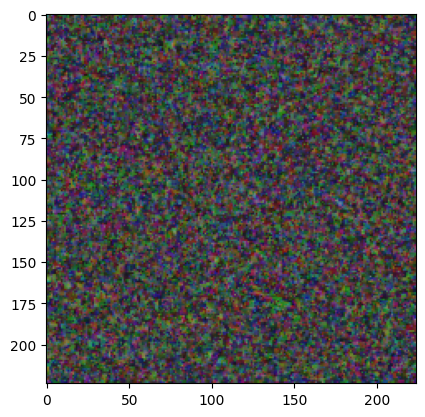

In [327]:
plt.imshow((class_images[71][3])**2)

<IPython.core.display.Javascript object>


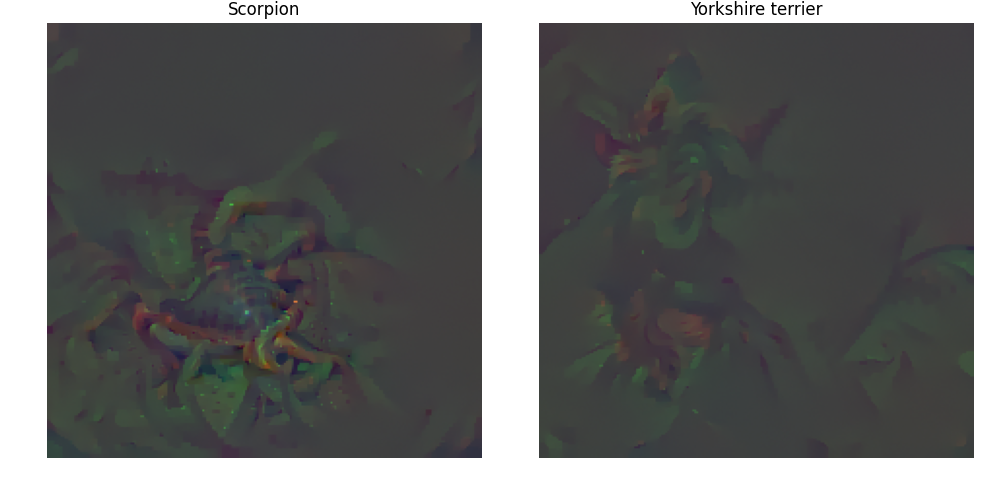

In [367]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter, PillowWriter 
%matplotlib notebook
# fig, ax = plt.subplots()
xdata, ydata = [], []
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout()
axs[0].axis('off')
axs[1].axis('off')
ln1 = axs[0].imshow(class_images[71][0]**2)
ln2 = axs[1].imshow(class_images[187][0]**2)
axs[0].set_title("Scorpion")
axs[1].set_title("Yorkshire terrier")

def init():
#     ax.set_xlim(0, 2*np.pi)
#     ax.set_ylim(-1, 1)
    return ln1, ln2

def update(data):
    frame1, frame2 = data
#     xdata.append(frame)
#     ydata.append(np.sin(frame))
    ln1.set_data(frame1**2)
    ln2.set_data(frame2**2)
    return ln,

data_gen = ((frame1, frame2) for frame1, frame2 in zip(class_images[71], class_images[187]))

ani = FuncAnimation(fig, update, frames=data_gen, save_count=1000,
                    init_func=init, blit=True)

writergif = PillowWriter(fps = 5)
ani.save('scorpio_dog.gif', writer=writergif)

# plt.show()

In [262]:
# import pickle

# with open("class_images", "wb") as f:
#     pickle.dump(class_images, f)

In [263]:
im = net.modify()
# net()
def rotate(im):
    return np.rot90(np.rot90(np.rot90(im)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


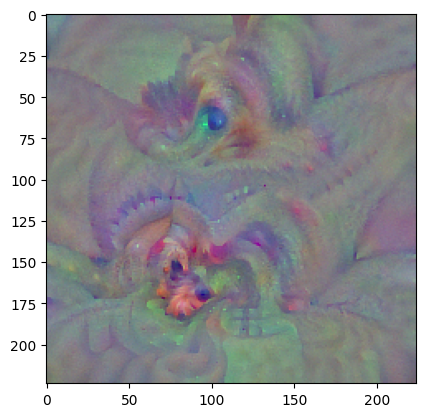

In [264]:
plt.imshow(rotate(np.squeeze(im.detach().numpy()).T))
# plt.imshow(images[-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


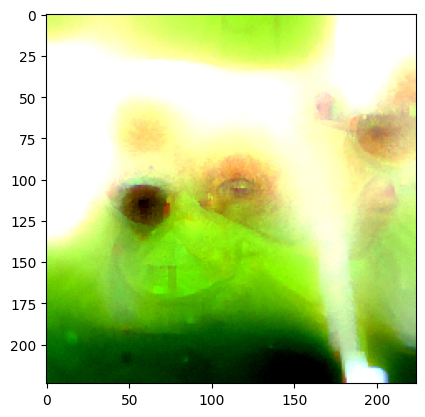

In [79]:
plt.imshow(rotate(np.squeeze(batch_t.detach().numpy()).T))

In [45]:
def revert_processing(img):
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    img = (img * std) + mean  # de-normalize
    img = np.clip(img, 0., 1.)  # make sure it's in the [0, 1] range
    return img

# good_enough = np.load("good_enough.npy")
# good_enough = (good_enough)
# im_org = revert_processing(rotate(img_t.numpy().T))

In [145]:
good_enough.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


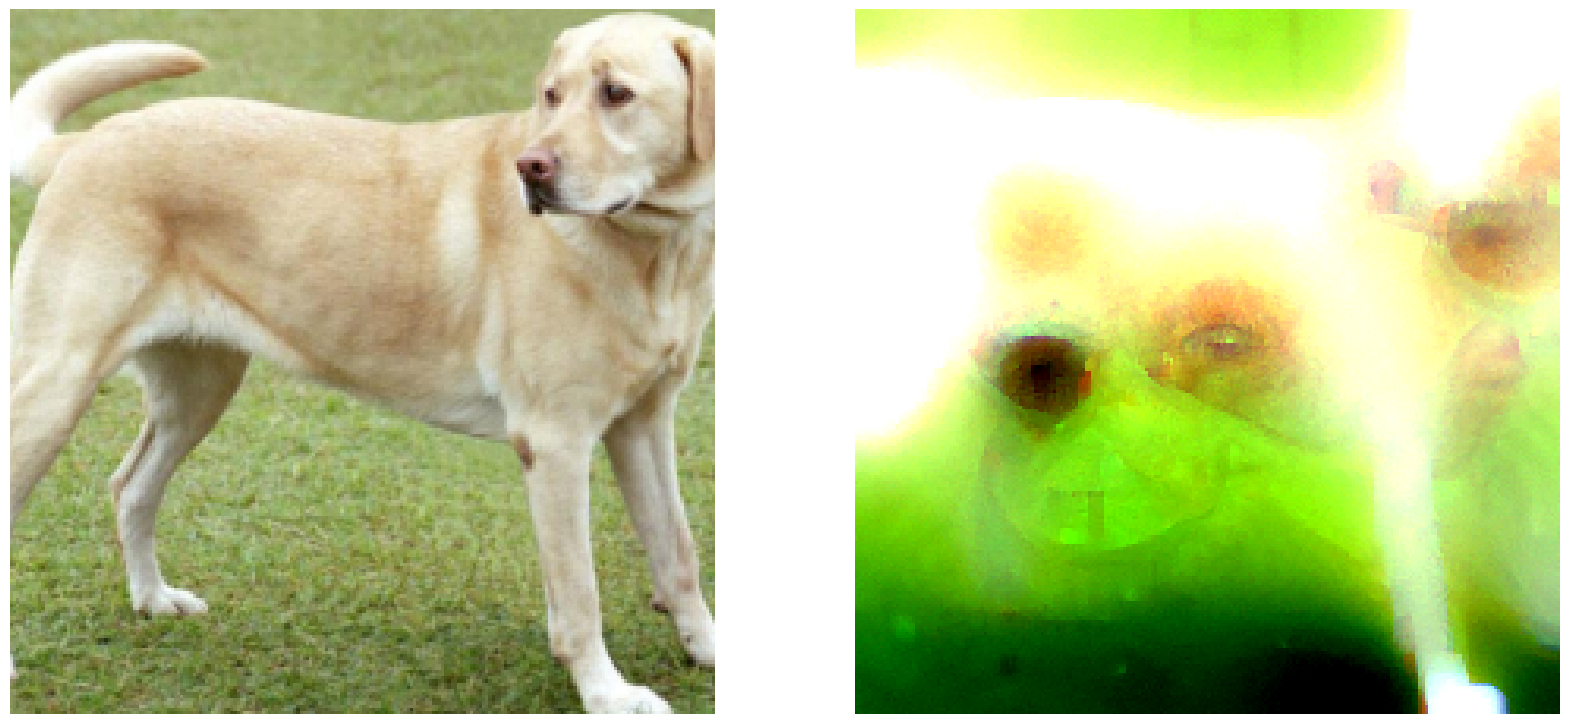

In [146]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(im_org)
axs[1].imshow(good_enough)
axs[0].set_axis_off()
axs[1].set_axis_off()